# Creating Table of features from datas

In [2]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

## Imprting datasets
For the dataset we will use
- ibd_userfile_new_production
- radioactivity_userfile_7days

for the background.

In [3]:
file_BKG = up.open("../../../../mnt/fcufino/radioactivity_userfile_1days.root")
#file_IBD = up.open('../BrutalCuts/unoscillated_IBD_userfile.root') 
#file_IBD = up.open('../../../../mnt/fcufino/ibd_userfile_1500days_tprecision.root')
file_IBD = up.open('../../../../mnt/data/userfiles/ibd_userfile_new_production.root')


dataset_IBD_all = file_IBD['TRec'].arrays(library = 'np')
dataset_BKG = file_BKG['TRec'].arrays(library = 'np')

dataset_IBD = {}
for key in ['recx', 'recy', 'recz', 'm_QEn', 'timestamp', 'SimID']:
    dataset_IBD[key] = dataset_IBD_all[key]


#Adding SimID to the BKG dataset
dataset_BKG["SimID"] = np.arange(len(dataset_BKG["m_QEn"]))

FileNotFoundError: file not found

    '../../../../mnt/fcufino/radioactivity_userfile_1days.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [4]:
dataset_IBD_all["SimID"]
dataset_IBD_all["EventID"]

array([   0,    1,    2, ..., 1987, 1988, 1989])

In [9]:
print(dataset_IBD_all.keys())

dict_keys(['EventID', 'SimID', 'timestamp', 't_sec', 't_nanosec', 'recx', 'recy', 'recz', 'm_QEn', 'm_pe'])


In [3]:
print("IBD events: ", len(dataset_IBD["m_QEn"]))
print("BKG events: ", len(dataset_BKG["m_QEn"]))

IBD events:  2977856
BKG events:  8841188


## Creation of two tables of features
One for IBD events and one for BKG, keeping them separately.


The feature table will have those features ($\Delta t$, $\Delta r$, $E_p$, $E_d$,$R_{prompt}$, $R_{delayed}$, $Label$)

In [4]:
from numba import njit, prange

In [5]:
@njit(parallel = True)
def create_features_handle(x,y,z,E,t,SimID,expon_time_cut = 5 * 220e3):

    n = x.shape[0] - 1
      
    delta_time = n*[np.zeros(0)]
    delta_radius = n*[np.zeros(0)]
    E_pro = n*[np.zeros(0)]
    E_del = n*[np.zeros(0)] 
    R_prompt = n*[np.zeros(0)]
    R_delayed = n*[np.zeros(0)]
    Label = n*[np.zeros(0)]

    for i in prange(x.shape[0] - 1):

        mask = np.logical_and(t>t[i], (t - t[i]) < expon_time_cut)
        to_loop = np.nonzero(mask)[0] 

        for t_index in range(len(to_loop)):
            j = to_loop[t_index] 

            if (t[j] - t[i]) < expon_time_cut:
                if (j-i)<1000 and j>i: #provvisorio
                    delta_time[i] = np.append(delta_time[i], t[j] - t[i])
                    delta_radius[i] = np.append(delta_radius[i], np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2))
                    E_pro[i] = np.append(E_pro[i], E[i])
                    E_del[i] = np.append(E_del[i], E[j])
                    R_prompt[i] = np.append(R_prompt[i],np.sqrt((x[i])**2 + (y[i])**2 + (z[i])**2))
                    R_delayed[i] = np.append(R_delayed[i],np.sqrt((x[j])**2 + (y[j])**2 + (z[j])**2))
                    
                    if SimID[i] == SimID[j]:
                        Label[i] = np.append(Label[i], 1)
                    elif SimID[i] != SimID[j]:
                        Label[i] = np.append(Label[i], 0)

            else:
                print(i, j, t[j] - t[i], 'Qualcosa non va')
                break

    return delta_time, delta_radius, E_pro, E_del, R_prompt, R_delayed, Label

from iteration_utilities import deepflatten

# Funzione per fare un flatten dell'output di Numba
def create_features(x,y,z,E,t,SimID,expon_time_cut = 5 * 220e3):
    res = create_features_handle(x,y,z,E,t,SimID,expon_time_cut)
    out = []
    for vec in res:
        out.append(np.asarray(list(deepflatten(vec))))  
    return out

### For IBD events

In [6]:
features_IBD = {"delta_time": np.array([]), 
            "delta_radius": np.array([]),
            "E_pro": np.array([]),
            "E_del": np.array([]),
            "R_prompt": np.array([]),
            "R_delayed": np.array([]),
            "Label": np.array([])} 


features_IBD["delta_time"],features_IBD["delta_radius"],features_IBD["E_pro"],features_IBD["E_del"],features_IBD["R_prompt"],features_IBD["R_delayed"],features_IBD['Label']  = create_features(
    dataset_IBD["recx"],
    dataset_IBD["recy"],
    dataset_IBD["recz"],
    dataset_IBD["m_QEn"],
    dataset_IBD["timestamp"],
    dataset_IBD["SimID"])




In [7]:
print(features_IBD["delta_time"].shape[0])
print(features_IBD["delta_radius"].shape[0])
print(features_IBD["E_pro"].shape[0])
print(features_IBD["E_del"].shape[0])
print(features_IBD["R_prompt"].shape[0])
print(features_IBD["R_delayed"].shape[0])
print((features_IBD["Label"].sum()/features_IBD["Label"].shape[0]) * 100)

1475009
1475009
1475009
1475009
1475009
1475009
99.55091799439867


### For the BKG events

In [8]:
features_BKG = {"delta_time": np.array([]),
                "delta_radius": np.array([]),
                "E_pro": np.array([]),
                "E_del": np.array([]),
                "R_prompt": np.array([]),
                "R_delayed": np.array([]),
                "Label": np.array([])} 


features_BKG["delta_time"],features_BKG["delta_radius"],features_BKG["E_pro"],features_BKG["E_del"],features_BKG["R_prompt"],features_BKG["R_delayed"],features_BKG["Label"] = create_features(
        dataset_BKG["recx"],
        dataset_BKG["recy"],
        dataset_BKG["recz"],
        dataset_BKG["m_QEn"],
        dataset_BKG["m_triggerT"],
        dataset_BKG["SimID"])

In [9]:
print(features_BKG["delta_time"].shape[0])
print(features_BKG["delta_radius"].shape[0])
print(features_BKG["E_pro"].shape[0])
print(features_BKG["E_del"].shape[0])
print(features_BKG["R_prompt"].shape[0])
print(features_BKG["R_delayed"].shape[0])
print(features_BKG["Label"].shape[0])

993457
993457
993457
993457
993457
993457
993457


## Plots before the cut

Delta time

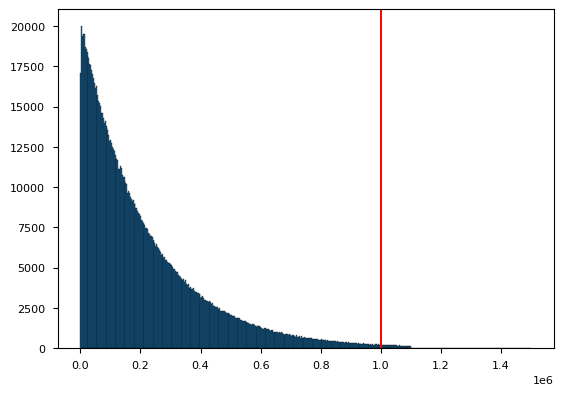

In [10]:
#plt.scatter(np.arange(features_IBD["delta_time"][ features_IBD['Label'] ==1].shape[0]), features_IBD["delta_time"][ features_IBD['Label'] ==1], s=1)
# plt.scatter(np.arange(features_BKG["delta_time"].shape[0]), features_BKG["delta_time"], s=1)
plt.hist(features_IBD["delta_time"][features_IBD['Label'] == 1], np.linspace(0, 1.5e6, 500))
plt.axvline(1e6, c = 'red')

Delta radius

Ne perdiamo:  17208


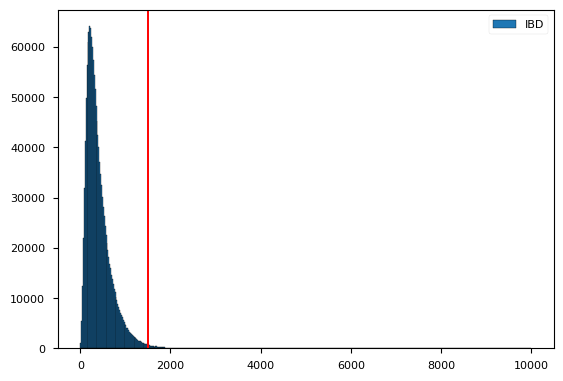

In [11]:
# plt.scatter(np.arange(features_IBD["delta_radius"][features_IBD['Label'] == 1].shape[0]), features_IBD["delta_radius"][ features_IBD['Label'] == 1], s=1)
# plt.scatter(np.arange(features_BKG["delta_radius"].shape[0]), features_BKG["delta_radius"], s=1)
plt.hist(features_IBD["delta_radius"][features_IBD['Label'] == 1], np.linspace(0, 1e4, 500))
# plt.hist(features_IBD["delta_radius"][features_IBD['Label'] == 0], np.linspace(0, 1e4, 10))
plt.legend(["IBD", "BKG"])
count = np.logical_and(True, features_IBD["delta_radius"]>1500)
print("Ne perdiamo: ", count.sum())
plt.axvline(1500, c = 'red')

# Merging the IBD and BKG tables, but the tables before the cuts 

In [18]:
def combine_dict(d1, d2):
    combined = {}
    for k in set(d1.keys()) | set(d2.keys()):
        if k in d1 and k in d2 and isinstance(d1[k], np.ndarray) and isinstance(d2[k], np.ndarray):
            combined[k] = np.concatenate([d1[k], d2[k]])
        elif k in d1:
            combined[k] = d1[k]
        else:
            combined[k] = d2[k]
    source = np.concatenate([np.full_like(d1.get(k, []), 1), np.full_like(d2.get(k, []), 0)])
    return {**combined, 'Source': source}
    

In [19]:
all_feature = combine_dict(features_IBD,features_BKG)
print(all_feature)

{'E_pro': array([5.26223   , 1.16043   , 4.45989   , ..., 0.48400998, 0.43437806,
       0.72712225]), 'delta_radius': array([  448.27860591,   321.95137047,   393.87693878, ...,
       14226.99707031, 31111.78125   , 24202.59179688]), 'Label': array([1., 1., 1., ..., 0., 0., 0.]), 'E_del': array([2.25358   , 2.25309   , 2.18264   , ..., 1.10824633, 2.00029159,
       0.56004959]), 'R_delayed': array([15381.68681502,  7549.91058534, 13683.06215751, ...,
       17399.        , 17399.        , 14583.58398438]), 'delta_time': array([528976., 243136.,  16304., ..., 750850.,  46371., 141066.]), 'R_prompt': array([15679.26747646,  7756.76478105, 13333.76935441, ...,
       12850.04296875, 17399.        , 17399.        ]), 'Source': array([1., 1., 1., ..., 0., 0., 0.])}


### Shuffle in random order

In [20]:
# ottieni il numero di righe in ogni array
n_rows = all_feature['E_del'].shape[0]

# crea un nuovo ordine casuale degli indici delle righe
new_order = np.random.permutation(n_rows)

# estrai le righe nei nuovi indici
for key in all_feature:
    all_feature[key] = all_feature[key][new_order]


In [21]:

print(all_feature)
print(all_feature['Label'].sum())

{'E_pro': array([4.90241   , 2.12466   , 2.10948   , ..., 2.72292352, 1.692     ,
       0.35823345]), 'delta_radius': array([  143.6652089 ,   180.09585448,   314.33367891, ...,
       34034.94140625,   632.71584908, 27854.82226562]), 'Label': array([1., 1., 1., ..., 0., 1., 0.]), 'E_del': array([2.27892   , 2.21941   , 2.26256   , ..., 0.97690666, 2.21436   ,
       1.31288648]), 'R_delayed': array([16483.59088559, 15446.85781849,  5157.15655333, ...,
       17399.        , 16572.51636455, 17399.        ]), 'delta_time': array([190096., 100080., 230800., ..., 699138.,  82096., 867009.]), 'R_prompt': array([16407.92629753, 15336.04502303,  5104.73810808, ...,
       17248.6015625 , 16216.50390994, 11569.71191406]), 'Source': array([1., 1., 1., ..., 0., 1., 0.])}
1468385.0


Statistics about the data

In [22]:
import pandas as pd
dataframe = pd.DataFrame({k:list(v) for k,v in all_feature.items()})
dataframe.describe()

,E_pro,delta_radius,Label,E_del,R_delayed,delta_time,R_prompt,Source
count,2.468466e+06,2.468466e+06,2.468466e+06,2.468466e+06,2.468466e+06,2.468466e+06,2.468466e+06,2.468466e+06
mean,2.390887e+00,8.667336e+03,5.948573e-01,1.666316e+00,1.404633e+04,3.486208e+05,1.405515e+04,5.975407e-01
std,2.097064e+00,1.108018e+04,4.909197e-01,1.515295e+00,3.505519e+03,3.034888e+05,3.494771e+03,4.903936e-01
min,0.000000e+00,6.084932e-01,0.000000e+00,0.000000e+00,0.000000e+00,6.400000e+02,5.884042e-09,0.000000e+00
25%,7.555603e-01,2.886269e+02,0.000000e+00,7.455531e-01,1.195644e+04,9.707200e+04,1.196440e+04,0.000000e+00
50%,2.217184e+00,6.486227e+02,1.000000e+00,2.169400e+00,1.502750e+04,2.497920e+05,1.503730e+04,1.000000e+00
75%,3.587890e+00,1.854104e+04,1.000000e+00,2.227280e+00,1.730813e+04,5.451360e+05,1.730879e+04,1.000000e+00
max,3.913881e+02,3.479771e+04,1.000000e+00,3.913881e+02,1.740007e+04,1.099999e+06,1.740007e+04,1.000000e+00


In [23]:
# import seaborn as sns


# g = sns.PairGrid(dataframe, hue="Label", hue_kws={"marker": ["o", "s"]})


# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()



# Saving data

In [24]:
print(all_feature.keys())

dict_keys(['E_pro', 'delta_radius', 'Label', 'E_del', 'R_delayed', 'delta_time', 'R_prompt', 'Source'])


I've tried using root but it did not worked 

In [25]:

# import ROOT

# root_file = ROOT.TFile("Data/all_feature.root", "recreate")

# tree = ROOT.TTree("all_feature", "Tree with all features")

# # create a ROOT TBranch for each array
# branches = {}
# for key in all_feature.keys():
#     branches[key] = tree.Branch(key, all_feature[key], f"{key}[{len(all_feature[key])}]/F")

# # fill the tree with the array data
# for i in range(len(all_feature['delta_time'])):
#     for key in all_feature.keys():
#         all_feature[key][i] = (i+1)*(key+1)  # set each element to a different value
#         branches[key].Fill()   # fill the branch for this key only


# # write the tree to the ROOT file
# root_file.Write()
# root_file.Close()

In [26]:
print(all_feature)

{'E_pro': array([4.90241   , 2.12466   , 2.10948   , ..., 2.72292352, 1.692     ,
       0.35823345]), 'delta_radius': array([  143.6652089 ,   180.09585448,   314.33367891, ...,
       34034.94140625,   632.71584908, 27854.82226562]), 'Label': array([1., 1., 1., ..., 0., 1., 0.]), 'E_del': array([2.27892   , 2.21941   , 2.26256   , ..., 0.97690666, 2.21436   ,
       1.31288648]), 'R_delayed': array([16483.59088559, 15446.85781849,  5157.15655333, ...,
       17399.        , 16572.51636455, 17399.        ]), 'delta_time': array([190096., 100080., 230800., ..., 699138.,  82096., 867009.]), 'R_prompt': array([16407.92629753, 15336.04502303,  5104.73810808, ...,
       17248.6015625 , 16216.50390994, 11569.71191406]), 'Source': array([1., 1., 1., ..., 0., 1., 0.])}


In [27]:
np.savetxt("../../../../mnt/fcufino/all_features.csv", np.column_stack(list(all_feature.values())), delimiter=",", header=",".join(list(all_feature.keys())), comments="")